In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

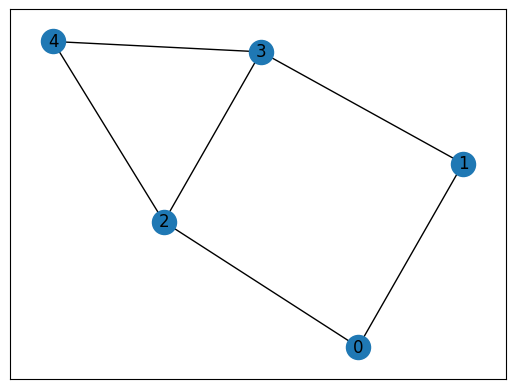

In [3]:
G = nx.house_graph()
nx.draw_networkx(G)

In [4]:
adj_matrix = nx.adjacency_matrix(G).todense()
degrees    = np.array(adj_matrix).sum(axis=0)
deg_matrix = np.diag(degrees)
lap_matrix = deg_matrix - adj_matrix

print('Adjacency Matrix (A)')
print(adj_matrix)
print()

print('Degree Matrix (D)')
print(deg_matrix)
print()

print('Laplacian Matrix (D-A)')
print(lap_matrix)
print()

Adjacency Matrix (A)
[[0 1 1 0 0]
 [1 0 0 1 0]
 [1 0 0 1 1]
 [0 1 1 0 1]
 [0 0 1 1 0]]

Degree Matrix (D)
[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 3 0 0]
 [0 0 0 3 0]
 [0 0 0 0 2]]

Laplacian Matrix (D-A)
[[ 2 -1 -1  0  0]
 [-1  2  0 -1  0]
 [-1  0  3 -1 -1]
 [ 0 -1 -1  3 -1]
 [ 0  0 -1 -1  2]]



In [5]:
# same result from using nx's implementation
nx.laplacian_matrix(G).toarray()

array([[ 2, -1, -1,  0,  0],
       [-1,  2,  0, -1,  0],
       [-1,  0,  3, -1, -1],
       [ 0, -1, -1,  3, -1],
       [ 0,  0, -1, -1,  2]])

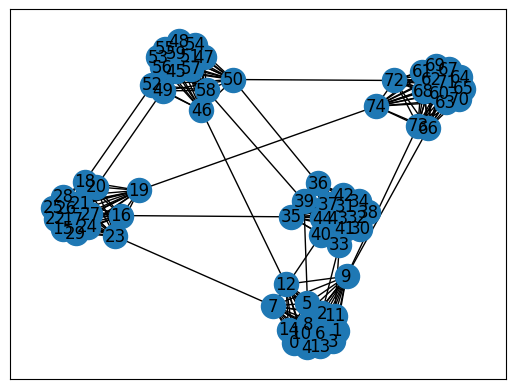

In [18]:
# generate a network with clear clusters
CLUSTER_SIZE = 15
NUM_CLUSTERS = 5
CONNECTIVITY = 0.005

clusters   = [nx.complete_graph(CLUSTER_SIZE) for _ in range(NUM_CLUSTERS)]
G          = nx.disjoint_union_all(clusters)
num_points = CLUSTER_SIZE * NUM_CLUSTERS

# TODO: optimise using some np implementation
for p1 in range(num_points):
    for p2 in range(p1+1, num_points):
        c1 = p1 % CLUSTER_SIZE
        c2 = p2 % CLUSTER_SIZE
        if c1 == c2: continue

        if random.uniform(0, 100) >= CONNECTIVITY * 100: continue
        G.add_edge(p1, p2)

nx.draw_networkx(G, ax=plt.axes(), with_labels=True)

In [19]:
# extract its laplacian, calculate its eigenvectors and values
lap = nx.laplacian_matrix(G).todense()
eig_val, eig_vec = np.linalg.eig(lap)

eig_val = eig_val.real
eig_vec = eig_vec.real

print('Eigenvalues')
eig_val[:10]

Eigenvalues


array([6.95343596e-01, 5.30631807e-16, 4.63211398e-01, 3.41259253e-01,
       2.71083121e-01, 1.78490930e+01, 1.78694878e+01, 1.79825124e+01,
       1.74410536e+01, 1.66542861e+01])

In [20]:
# view the sorted eigenvalues (just first 10)

N = G.number_of_nodes()
sorted(eig_val)[:10]

[5.306318074316841e-16,
 0.27108312078356245,
 0.34125925255399275,
 0.4632113983061741,
 0.6953435961113081,
 14.999999999999973,
 14.999999999999982,
 14.999999999999984,
 14.999999999999986,
 14.999999999999988]

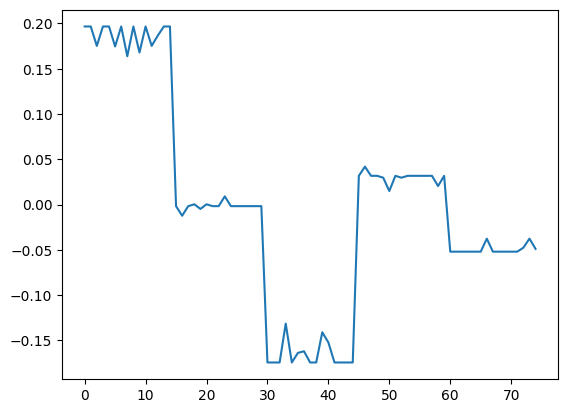

In [21]:
# there seems to be a strong cutoff at 10
# calculate the fiedler eigenvector as a measure of graph connectivity

i = np.where(eig_val<10)[0]
plt.plot(eig_vec[:,i[0]])

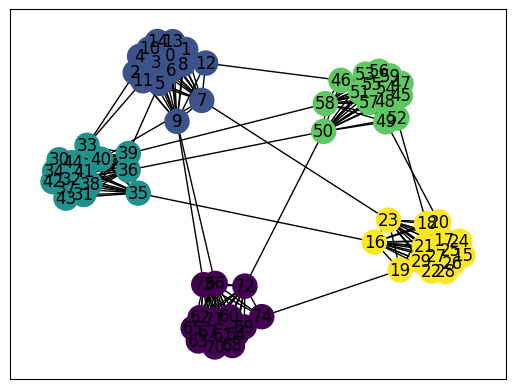

In [22]:
from sklearn.cluster import KMeans

# get rid of the complex part of Fiedler eigenvector
real_values = np.array(eig_vec[:,i[0]], dtype=np.float64).reshape(-1, 1)

# train a KMeans Clustering Model on the Fiedler eigenvector
kmeans_model = KMeans(n_clusters=NUM_CLUSTERS).fit(real_values)
cluster_labels = kmeans_model.labels_
nx.draw_networkx(G, node_color=cluster_labels)

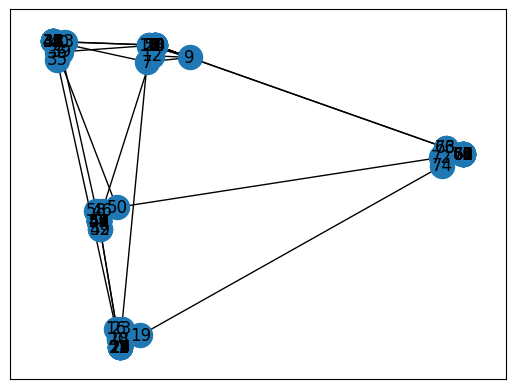

In [23]:
nx.draw_networkx(G, pos=nx.spectral_layout(G))